In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
rng = np.random
from array import array
from scipy import stats

#Keras import 
import keras.backend as K
from keras.models import *
from keras.layers import *

from keras import optimizers
from keras.callbacks import *

#import models
#from Linear_Regression import linear_regression 

#import datetime for tensorboard
from datetime import *

#Import for reading the MATLAB files
import glob

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Load EEG data of all subjects 

In [3]:
def load_eeg_data():
    '''
    Function to load EEG data of all subjects 
    '''
    eeg_data = []
    for name in glob.glob('*.mat'):
        # data import from matlab
        subject = sio.loadmat(name)   #Load the matlab file for a single subject 
        data_subject = subject['data']


        # shuffle trials
        (channel, trial, time_points)= data_subject.shape

        trials = np.arange(trial)
        np.random.shuffle(trials)

        #Z score
        data_subject=stats.zscore(format_1, axis=2)
        
        eeg_data.append(data_subject)
    return np.array(eeg_data)    
        

In [4]:
!ls

1.mat                                 Linear_Regression.ipynb
1filtered.mat                         Linear_Regression.py
2.mat                                 __pycache__
3.mat                                 linear_reg python3final7.ipynb
4.mat                                 linear_reg python3final7_keras.ipynb
5.mat                                 logs
EEG_Data_to_Process                   vanilla_RNN python3final7_keras.ipynb


In [5]:


# data import from matlab
subject_1 = sio.loadmat('1.mat')      #recovering matlab data in the form of a python dictionar
format_1 = subject_1['data']          #in the dictionary, only the data key interests us
print (format_1.shape)

# shuffle trials
(channel, trial, time_points)= format_1.shape

trials = np.arange(trial)
np.random.shuffle(trials)

#Z score
format_1=stats.zscore(format_1, axis=2)

(65, 192, 1000)


In [6]:
eeg_data = load_eeg_data()

In [7]:
print(type(format_1))

<class 'numpy.ndarray'>


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


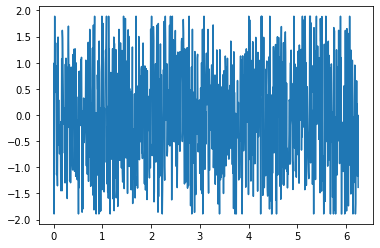

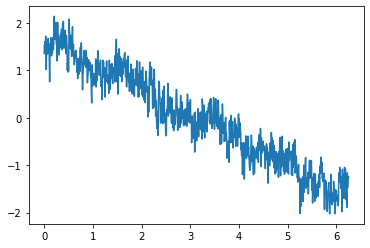

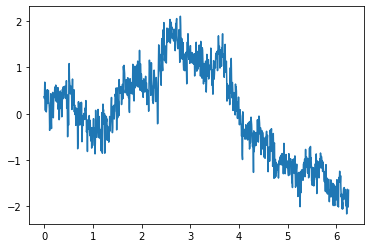

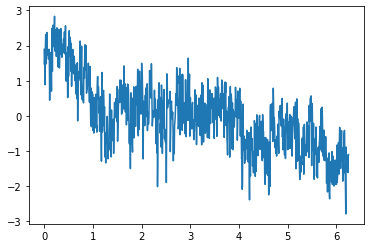

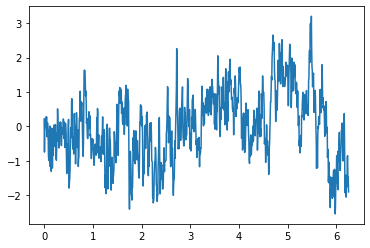

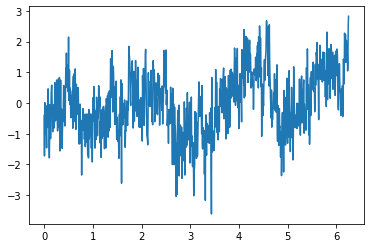

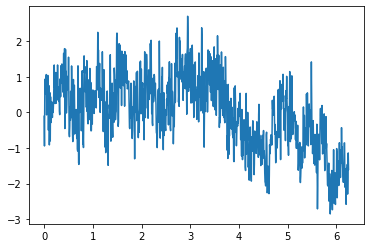

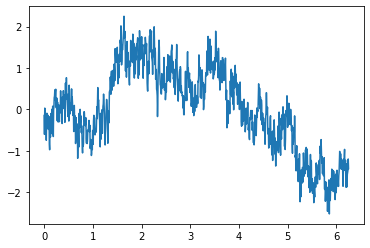

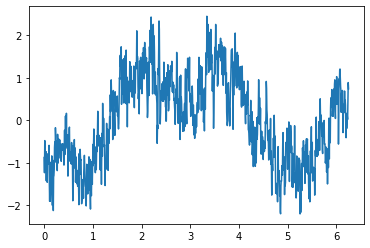

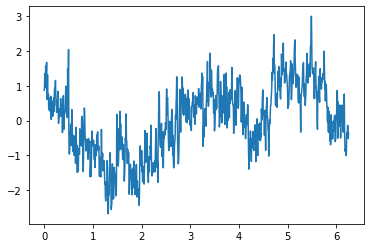

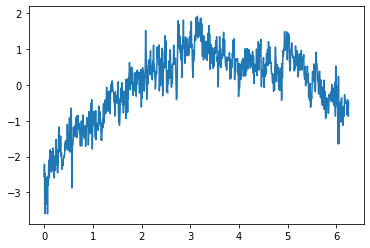

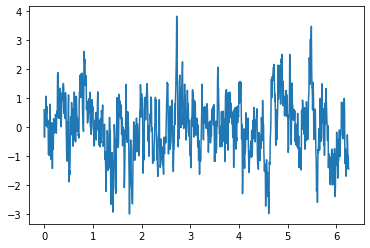

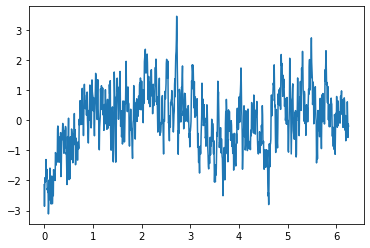

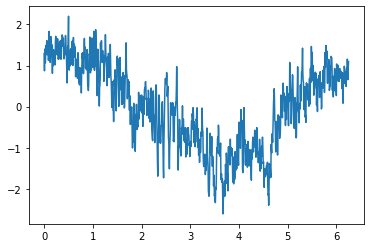

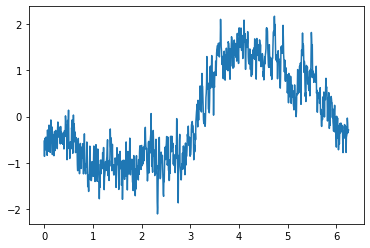

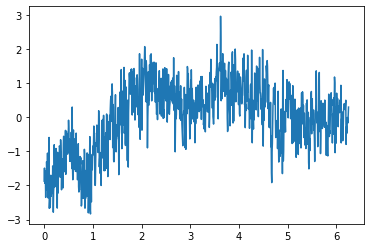

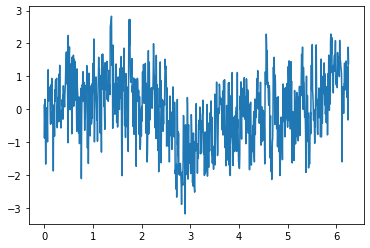

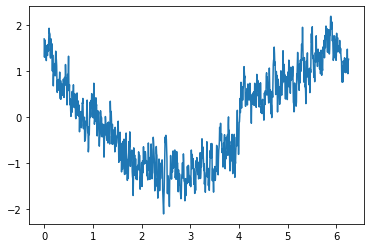

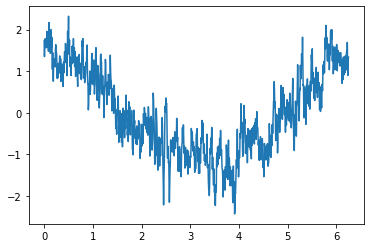

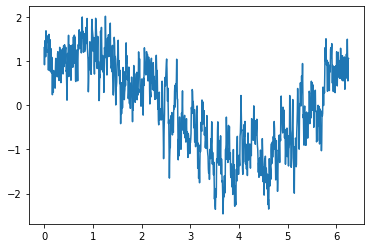

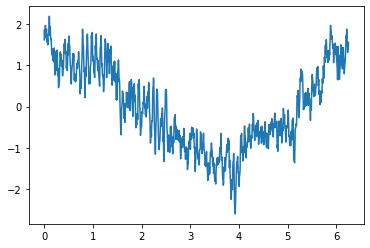

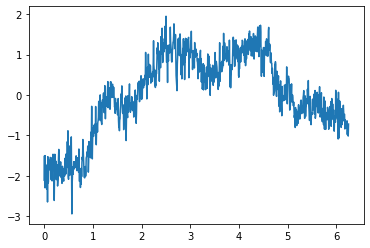

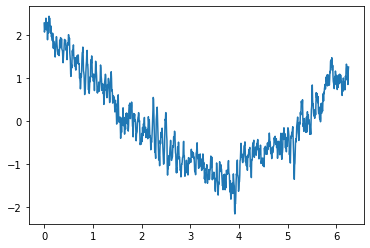

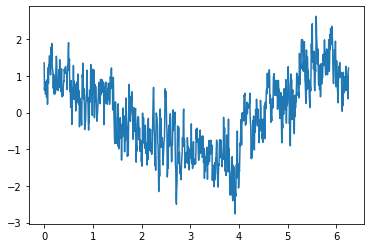

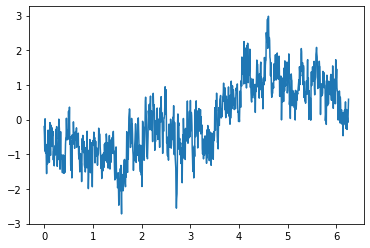

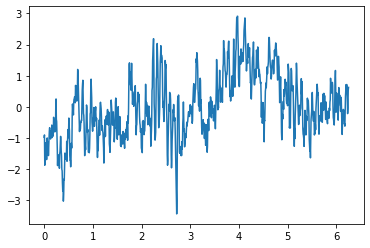

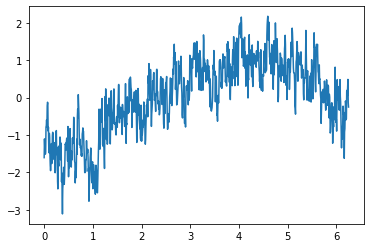

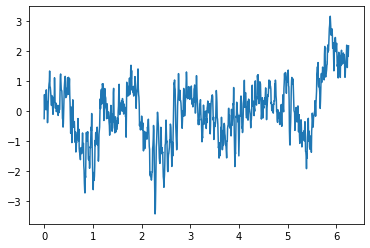

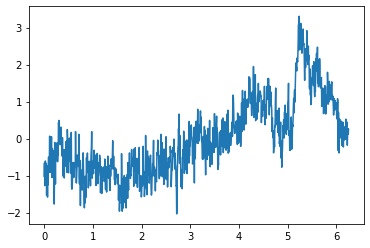

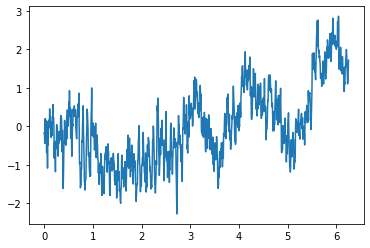

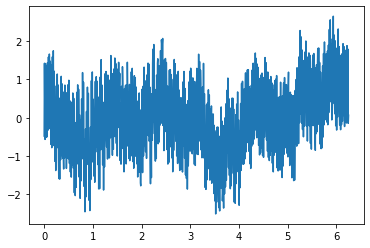

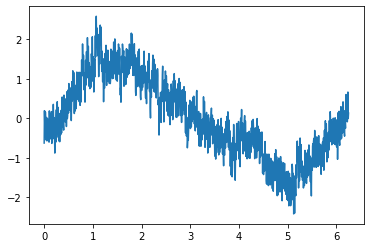

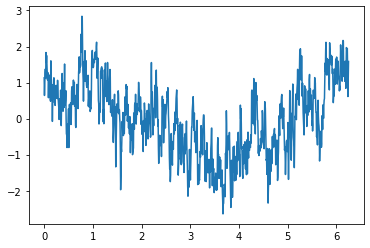

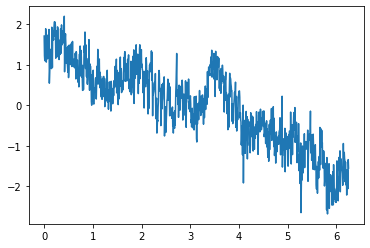

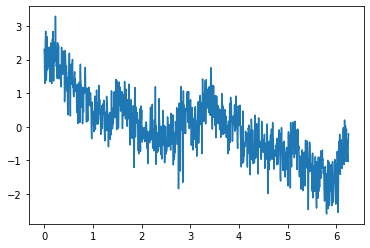

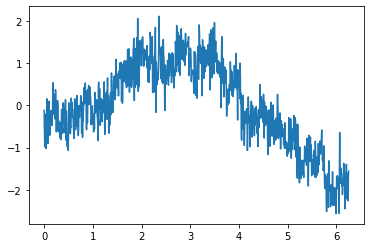

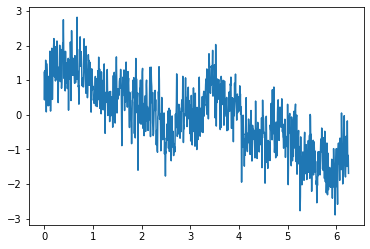

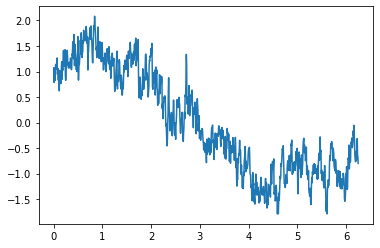

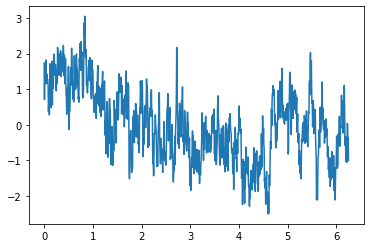

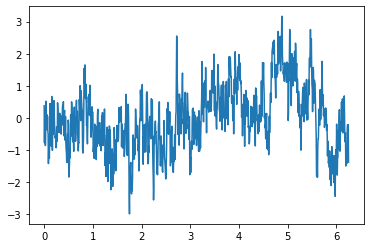

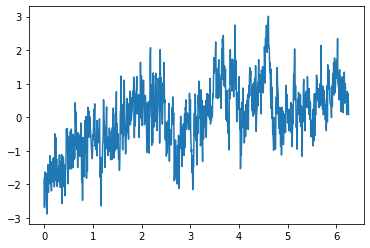

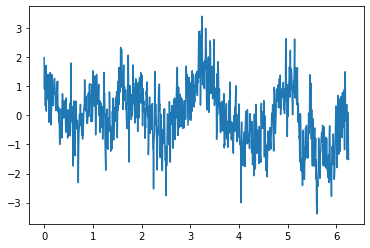

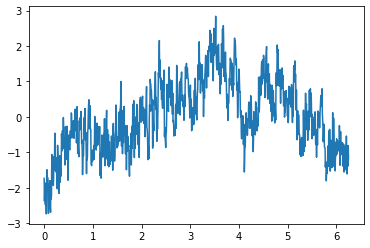

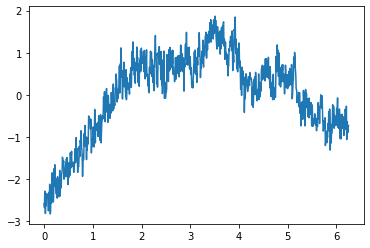

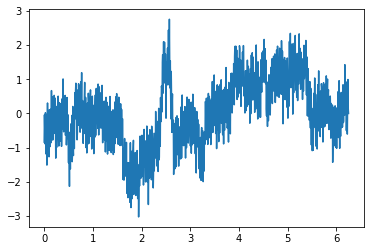

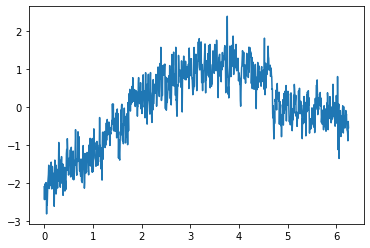

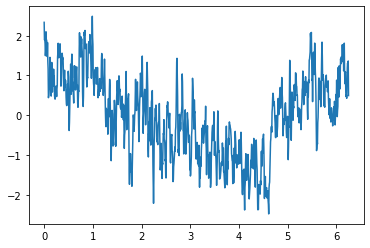

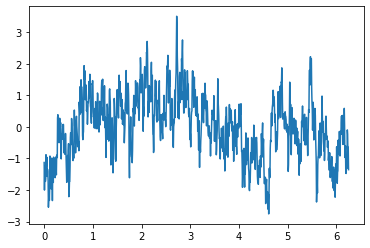

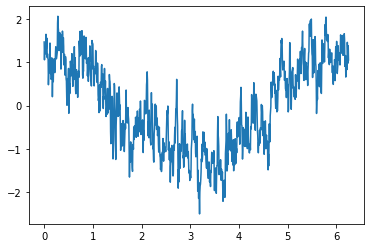

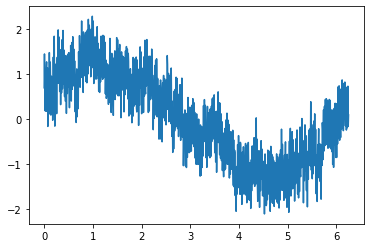

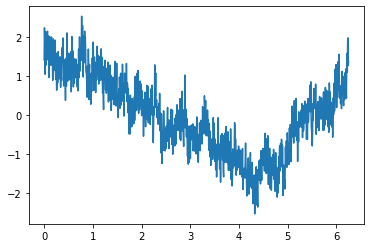

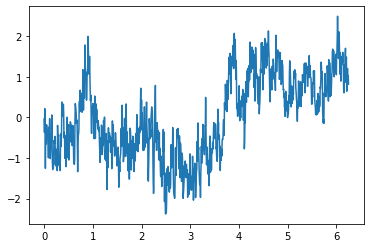

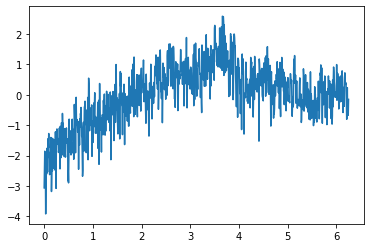

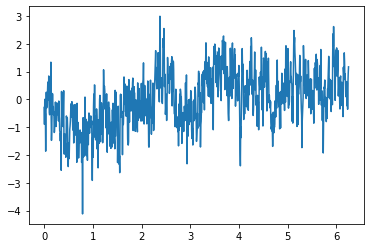

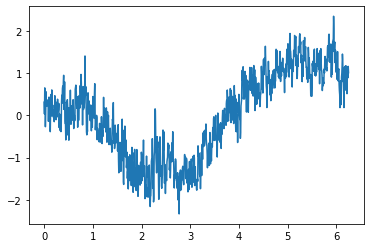

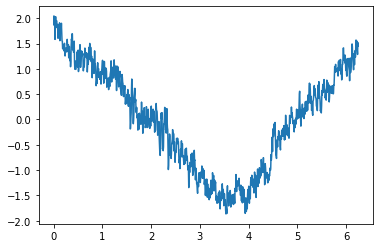

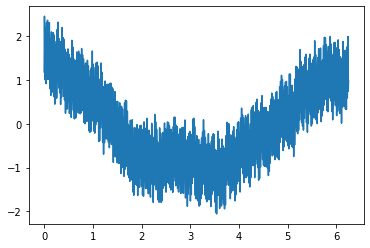

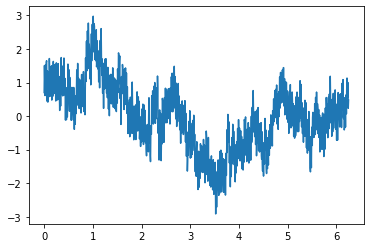

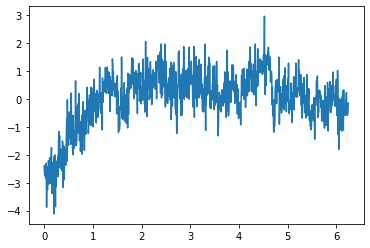

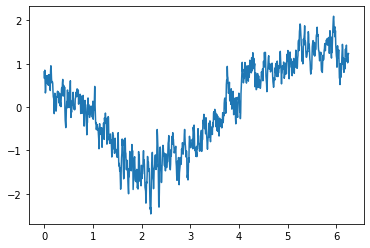

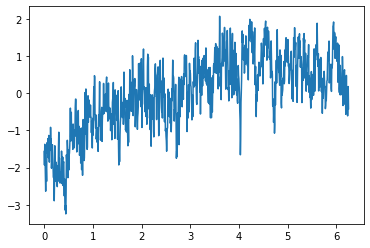

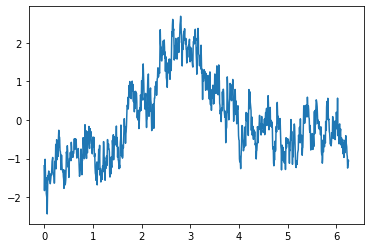

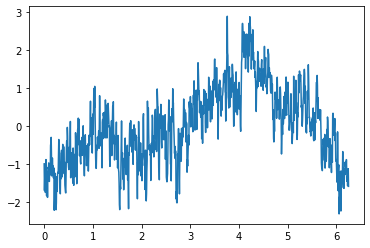

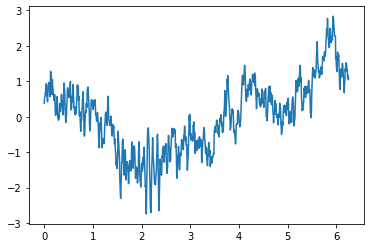

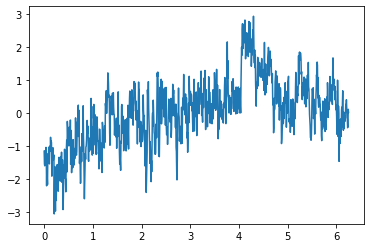

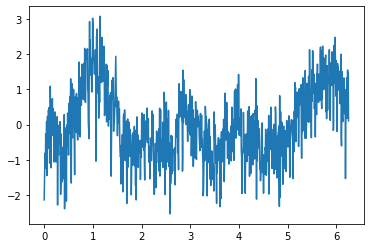

In [8]:
#Plot EEG
#plot of a single channel of EEG
%matplotlib inline
Time = np.linspace(0, 6.25, 1000)
for i in range (channel):
    plt.plot(Time, format_1[i][0])
    plt.figure()

plt.plot(Time, format_1[52][1])



In [9]:
# parametres

eltmp = input ('''Enter the electrode number:''')
electi = list(map(int, eltmp.split()))    #separation of the different responses and recovery in the form of a list of integers
print (type(electi))
print(electi)

stim = input ('''Enter the number of stimuli:''')
stim = int(stim)

relation = input('''Please define what should be predicted (1 for EEG or 2 for stimulus):''')

if relation == '1':
    source_Y = electi[0]    #retrieving the electrode number as a whole number - implies that there is only one electrode chosen in this direction
    source_X = [0]          #conversion of the stimuli line in the form of a list - necessary for the for loop: see below - extraction X

elif relation == '2':
    format_1 = np.flip(format_1,2)     # data inversion according to the time dimension - problem ????
    source_Y = 0
    source_X = electi

hiLaSi_tmp = input('''please specify the number of layers and neurons per desired layers: ''')
hidden_layers = list(map(int, hiLaSi_tmp.split()))
print (hidden_layers)
print (type(hidden_layers))

learning_rate = input('''enter the lambda / learning rate: ''')
learning_rate = float(learning_rate)      # conversion as a decimal number

Enter the electrode number:40
<class 'list'>
[40]
Enter the number of stimuli:160
Please define what should be predicted (1 for EEG or 2 for stimulus):1
please specify the number of layers and neurons per desired layers: 1
[1]
<class 'list'>
enter the lambda / learning rate: 0.001


In [10]:
def split_data(data):
    (subject, channel, trial, time_points) = data.shape
    
    #Sepration of train train / valid / test sets into 80 %, 10 % and 10 % of the data respectively.
    
    train_num = int(np.around(len(trials) * 0.8))
    valid_num = int(np.around(len(trials) * 0.1))
    test_num = len(trials) - train_num - valid_num
    
    

In [11]:
#### separation of train tests / valid / test

train_num = int(np.around(len(trials) * 0.8))
valid_num = int(np.around(len(trials) * 0.1))
test_num = len(trials) - train_num - valid_num

trials_train = trials[0:train_num]
trials_valid = trials[train_num:train_num+valid_num]
trials_test = trials[train_num+valid_num:]

In [12]:
# extract data from format_1

def extract_Y (batch_trials, batch_num):              #creation of a function to recover y - simplification of reading
    
    y_tmp=format_1[source_Y, batch_trials, stim:]     #recovery of Y in the form of a matrix of 154 * 840
    y_tmp=np.reshape(y_tmp, ((time_points-stim)*batch_num))    #passage through the list of 129 360 values ​​(test 0, test 1, ... test 153)
    y_tmp=np.matrix(y_tmp)                           #1 * 129360 matrix conversion
    y_tmp=np.transpose(y_tmp)                        #transposition into a matrix of 129360 * 1, matrix equal to that of Matlab (necessary for the rest)
    return y_tmp                                     #returns the content of y_tmp
    
y_train = extract_Y (trials_train, train_num)
print ("y_train.shape = ", y_train.shape)
y_valid = extract_Y (trials_valid, valid_num)
print ("y_valid.shape = ", y_valid.shape)
y_test = extract_Y (trials_test, test_num)
print ("y_test.shape = ", y_test.shape)

y_train.shape =  (129360, 1)
y_valid.shape =  (15960, 1)
y_test.shape =  (15960, 1)


In [47]:
def extract_X (batch_trials, batch_num):                     #creation of a function to recover x - simplification of reading
    x_tmp = [[]]*((time_points-stim)*batch_num)                       #creation of an empty list x_tmp of size (129630,)
    x_tmp = np.matrix(x_tmp)                                #conversion as a matrix 129630 * 0 (number of lines good)
    x_tmp = np.transpose(x_tmp)                             #transposition 1: form 0 * 129630, necessary at n.append
                                                            #avoid the transposition line in the for loop (2 transpo instead of 160
    for i in source_X:                                      #reading the source list -> reading each electrode number if flip
        k = 0
        while k < stim:                                     #160 loops - recovery of the 840 values ​​of each test (in the form test 1, test 2, ...), shifted by 1 at each iteration
            tmp = format_1[i, batch_trials, k:(time_points-stim+k)]    #see extract_Y
            tmp = np.reshape(tmp,((time_points-stim)*batch_num))
            tmp = np.matrix(tmp)
            
            x_tmp = np.append(x_tmp, tmp, axis=0)           #concatenation of the matrix tmp 1 * 129360 at the end of the matrix x_tmp (k + 1) * 129360
            k = k+1
    x_tmp = np.transpose(x_tmp)                             #transposition 2: form 129360 * (160 * nbr_électrode)
    return x_tmp
        
x_train = extract_X (trials_train, train_num)
print ("x_train.shape = ", x_train.shape)
x_valid = extract_X (trials_valid, valid_num)
print ("x_valid.shape = ", x_valid.shape)
x_test = extract_X (trials_test, test_num)
print ("x_test.shape = ", x_test.shape)

x_train.shape =  (129360, 160)
x_valid.shape =  (15960, 160)
x_test.shape =  (15960, 160)


In [48]:
#tensorflow - Linear regression cf github

training_epochs = 100
display_step = 10

train_X = x_train
print(train_X.shape)
train_Y = y_train
print(train_Y.shape)
n_samples_train = train_X.shape[0]

valid_X = x_valid
valid_Y = y_valid
n_samples_valid = valid_X.shape[0]

test_X = x_test
test_Y = y_test
n_samples_test = test_X.shape[0]

(129360, 160)
(129360, 1)


In [49]:
#Add extra dimension to train_X for input to Sequence models 
train_X = np.expand_dims(train_X, axis = -1)
valid_X = np.expand_dims(valid_X, axis = -1)
test_X = np.expand_dims(test_X, axis = -1)

In [35]:
def vanilla_RNN():
    inp = Input([None, 1])
    X = SimpleRNN(400, return_sequences = True)(inp)
    X = SimpleRNN(400)(X)
    out = Dense(1)(X)
    
    model = Model(inputs = inp, outputs = out)
    return model 
    
    

In [16]:
#Define Keras Model 
model = model = vanilla_RNN()


Instructions for updating:
Colocations handled automatically by placer.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [17]:
hidden_layers

[1]

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, None, 400)         160800    
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 400)               320400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 401       
Total params: 481,601
Trainable params: 481,601
Non-trainable params: 0
_________________________________________________________________


In [39]:
#Set Up Tensorboard for visualisation for training
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir, write_images = True, histogram_freq = 2)


In [42]:
#Define training Loss 
def mse(y_true, y_pred):
    return (K.mean(K.square(y_pred - y_true), axis = -1)) / 2

In [43]:
#Set up the Optimizers
sgd = optimizers.SGD(learning_rate)
adam = optimizers.Adam(lr = learning_rate)
rmsprop = optimizers.RMSprop(lr = learning_rate)

#Compile the model
model.compile(loss = mse, optimizer = sgd , metrics=[mse])

In [50]:
#Fit the model with the Data
model.fit(
    train_X, 
    train_Y, 
    epochs = training_epochs, 
    validation_data = (valid_X, valid_Y), 
    verbose = 1,
    callbacks = [tensorboard_callback])

Instructions for updating:
Use tf.cast instead.
Train on 129360 samples, validate on 15960 samples
Epoch 1/100
 21024/129360 [===>..........................] - ETA: 18:46 - loss: 0.4770 - mse: 0.4770

KeyboardInterrupt: 

In [24]:
score = model.evaluate(test_X, test_Y)
print("Test Loss:", score[0])


15960/15960 [==============================] - 0s 13us/step
Test Loss: 0.48003955786128094


In [25]:
#Graphical Display to plot weights
def plot_weights(weights, electi):
 
        
    T = np.arange(0, 0.00625*stim, 0.00625)                       # creation of the time variable (on 1s) for the abscissa
    
    nbr_elct = len(electi)
    (Lo_W, la_W) = weights[0].shape
    Lo_W = int(Lo_W)                                              # number of lines: inputs (160 * nbr_electrodes, for example)
    la_W = int(la_W)                                              # number of columns: number of neurons in the layer
    
    z=0
    while z < nbr_elct:                                           # for each electrode
        z_1=0 
        while z_1 < la_W:                                         # for each neuron of the W layer [1]
            W_tmp = tf.slice(K.constant(weights[0]), [0, z_1], [Lo_W, 1])           # slice: starting value [line 0, column of the neuron], dimensions of the section [160 * nbr_electrodes lines, 1 column])
            W_tmp = tf.slice(W_tmp, [z*stim, 0], [stim, 1])       # slice: starting value [first value of the new electrode, column 0], dimensions of the section [160 lines, 1 column]
            print (W_tmp.shape)
            
            plt.plot(T, K.eval(W_tmp), label= ("neurone_", z_1, "layer_1, electrode_", electi[z]))
            z_1 = z_1+1
            
        z = z+1
        
    plt.legend()    
    plt.show()
    

(160, 1)


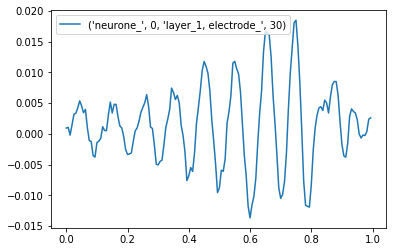

In [26]:
weights = np.array(model.get_weights()) #Convert the weights into np array

plot_weights(weights, electi)            #Plot the weights of the model

In [80]:
weights.shape

(2,)